<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка текста</a></span></li><li><span><a href="#Стоп-слова-и-счетчик" data-toc-modified-id="Стоп-слова-и-счетчик-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Стоп-слова и счетчик</a></span></li><li><span><a href="#Выводы-блока-(Подготовка):" data-toc-modified-id="Выводы-блока-(Подготовка):-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Выводы блока (Подготовка):</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-№1-LogisticRegression" data-toc-modified-id="Модель-№1-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель №1 LogisticRegression</a></span></li><li><span><a href="#Модель-№2-PassiveAggressiveClassifier" data-toc-modified-id="Модель-№2-PassiveAggressiveClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель №2 PassiveAggressiveClassifier</a></span></li><li><span><a href="#Модель-№3-DecisionTreeClassifier" data-toc-modified-id="Модель-№3-DecisionTreeClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель №3 DecisionTreeClassifier</a></span></li><li><span><a href="#Выводы-блока-(Обучение-моделей):" data-toc-modified-id="Выводы-блока-(Обучение-моделей):-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выводы блока (Обучение моделей):</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Задача:**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нем содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
# загрузка библиотек
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import re
import nltk
import spacy
from tqdm import tqdm, notebook
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             TfidfTransformer,
                                             CountVectorizer)

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import (LogisticRegression,
                                  PassiveAggressiveClassifier)

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)

from sklearn.metrics import (f1_score,
                             confusion_matrix)

warnings.filterwarnings("ignore")

# загрузка стоп-слов
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

SEED=42

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--------------------------------------------------------------------------------------------------------------------------------------

### Загрузка данных

Ознакомимся с данными таблицы. Быстренько пробежимся по ним глазком, посмотрим, корректно ли все сохранилось, размер таблицы, есть ли пропуски или некорректное наименование столбцов.

* Столбец <i>text</i> — содержит комментарии пользователей;
* Столбец <i>toxic</i> — содержит информацию о наличии нецензурной лексики. 0 — нет нецензурной лексики, 1 — есть.

--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# загрузка данных
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    text_df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    text_df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [ ]:
# смотрим размеренность датафрейма
text_df.shape

(159292, 2)

In [ ]:
# загружаем лемматизированный, но еще не очищенный текст
lemm_text = pd.read_csv(os.getcwd()+'/lemma_text.csv', index_col=[0])
display(lemm_text.head(), lemm_text.shape)

,lemma_text
0,explanation \n why the edit make under my user...
1,d'aww ! he match this background colour I be s...
2,"hey man , I be really not try to edit war . it..."
3,""" \n more \n I can not make any real suggestio..."
4,"you , sir , be my hero . any chance you rememb..."


(159292, 1)

In [ ]:
# объединяем датафреймы
text_df = pd.concat([text_df, lemm_text], axis=1)
# проверяем
display(text_df, text_df.shape)

,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,explanation \n why the edit make under my user...
1,D'aww! He matches this background colour I'm s...,0,d'aww ! he match this background colour I be s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n more \n I can not make any real suggestio..."
4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,""" : : : : : and for the second time of asking ..."
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself \n\n that be...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,"spitzer \n\n umm , there s no actual article f..."
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


(159292, 3)

In [ ]:
# проверяем есть ли пропуски
text_df.isna().sum()

text          0
toxic         0
lemma_text    0
dtype: int64

In [ ]:
# общая информация о дф и размеренность
display(text_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   lemma_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


None

--------------------------------------------------------------------------------------------------------------------------------------

Взглянем на распределение значений в столбце toxic. Это поможет понять, есть ли в данных перекосы. Перед этим напомню:

- 0 — нет нецензурной лексики
- 1 — есть.

--------------------------------------------------------------------------------------------------------------------------------------

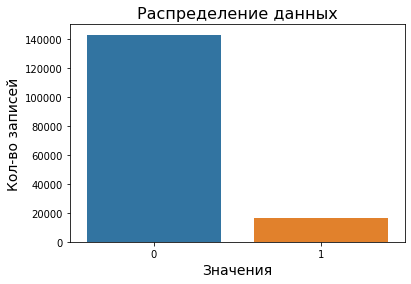

In [ ]:
sns.countplot(text_df['toxic'])
plt.title('Распределение данных', size=16)
plt.xlabel('Значения', size=14)
plt.ylabel('Кол-во записей', size=14);

--------------------------------------------------------------------------------------------------------------------------------------

На графике мы видим, что данные перекошены: записей с нецензурным текстом значительно больше, чем с цензурной лексикой. Иными словами есть дисбаланс классов, запомним эту деталь.

--------------------------------------------------------------------------------------------------------------------------------------

### Очистка текста

--------------------------------------------------------------------------------------------------------------------------------------

Очистим текст от ненужных символов: цифр, пунктуации и прочего.

--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# функция очищает текст от выше перечисленных символов
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    clear_text = clear_text.split()

    return " ".join(clear_text)


# проверим результат
print(f"Оригинальный текст:\n{text_df['lemma_text'][0]}")
print('_'*120)
print(f"Очищенный текст:\n{clear_text(text_df['lemma_text'][0])}")

Оригинальный текст:
explanation 
 why the edit make under my username hardcore metallica fan be revert ? they be not vandalism , just closure on some gas after I vote at new york doll fac . and please do not remove the template from the talk page since I be retire now.89.205.38.27
________________________________________________________________________________________________________________________
Очищенный текст:
explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I be retire now


In [ ]:
# очищаем лемматизированный текст от лишних символов
tqdm.pandas()
text_df['lemma_text'] = text_df['lemma_text'].progress_apply(lambda x: clear_text(x))
text_df

100%|██████████| 159292/159292 [00:05<00:00, 31120.20it/s]


,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there s no actual article for pros...
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


### Стоп-слова и счетчик

--------------------------------------------------------------------------------------------------------------------------------------

Создадим счетчик, фиксирующий частоту появления слов в тексте. Укажем стоп-слова на английском языке, чтобы программа их игнорировала. Для начала разделим данные таблицы на выборки для обучения моделей.

--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# разделяем данные на целевой и входные признаки
X = text_df['lemma_text']
y = text_df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

display(X_train.shape, y_test.shape)

(127433,)

(31859,)

In [ ]:
# инициализируем счетчик, указав стоп-слова
count_tf_idf = CountVectorizer(stop_words=stopwords)

# считаем величину TF-IDF для обучающей выборки
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)
display(tf_idf_train.shape, tf_idf_test.shape)

(127433, 133980)

(31859, 133980)

--------------------------------------------------------------------------------------------------------------------------------------
### Выводы блока (Подготовка):

- Загрузили данные;
- Окинули данные взглядом: пропусков и некорректностей обнаружено не было;
- Текст был обработан: проведена лемматизация и удалены лишние символы;
- Выполнена векторизация текста, данные разделены на выборки для обучения модели.


--------------------------------------------------------------------------------------------------------------------------------------

## Обучение моделей


### Модель №1 LogisticRegression

In [ ]:
pipeline = Pipeline([
 ('vect', CountVectorizer(min_df=40, ngram_range=(1,1), stop_words=stopwords)),
 ('tfidf', TfidfTransformer()),
 ('model',LogisticRegression(random_state=SEED))])

params={
        'model__C':[.01,.05,.1,.5,1,5,10],
        'model__penalty':['l1','l2']
}

randomized_search_lr = RandomizedSearchCV(pipeline,
                                         params,
                                         cv=5,
                                         n_jobs=-1,
                                          random_state=SEED,
                                         scoring='f1')

randomized_search_lr.fit(X_train, y_train)

# получаем время обучения модели
train_time_lr = round(randomized_search_lr.cv_results_['mean_fit_time'][randomized_search_lr.best_index_], 2)
# скорость предсказания модели
score_time_lr = round(randomized_search_lr.cv_results_['mean_score_time'][randomized_search_lr.best_index_], 2)
# метрика f1 модели
f1_lr = round(randomized_search_lr.best_score_, 2)

print(f'Время обучения модели LogisticRegression: {train_time_lr} сек.')
print(f'Время предсказания модели: {score_time_lr} сек.')
print(f"f1 LogisticRegression на тренировочной выборке: {f1_lr}")

Время обучения модели LogisticRegression: 5.79 сек.
Время предсказания модели: 0.98 сек.
f1 LogisticRegression на тренировочной выборке: 0.77


### Модель №2 PassiveAggressiveClassifier

In [ ]:
# инициализируем модель
model_pac = PassiveAggressiveClassifier(random_state=SEED)

# подбор гиперпараметров
params = {
    'C':[.01, .1, .5,],
    'max_iter': [20, 50, 100]
}

randomized_search_pac= RandomizedSearchCV(model_pac,
                                          params,
                                          cv=5,
                                          n_jobs=-1,
                                          scoring='f1',
                                          random_state=SEED)
# обучение модели
randomized_search_pac.fit(tf_idf_train, y_train)
# вывод лучших гиперпараметров
randomized_search_pac.best_estimator_

PassiveAggressiveClassifier(C=0.01, max_iter=100, random_state=42)

In [ ]:
# получаем время обучения модели
train_time_pac = round(randomized_search_pac.cv_results_['mean_fit_time'][randomized_search_pac.best_index_], 2)
# скорость предсказания модели
score_time_pac = round(randomized_search_pac.cv_results_['mean_score_time'][randomized_search_pac.best_index_], 2)
# метрика f1 модели
f1_pac = round(randomized_search_pac.best_score_, 2)

print(f'Время обучения модели PassiveAggressiveClassifier: {train_time_pac} сек.')
print(f'Время предсказания модели: {score_time_pac} сек.')
print(f"f1 PassiveAggressiveClassifier на тренировочной выборке: {f1_pac}")

Время обучения модели PassiveAggressiveClassifier: 1.71 сек.
Время предсказания модели: 0.01 сек.
f1 PassiveAggressiveClassifier на тренировочной выборке: 0.77


### Модель №3 DecisionTreeClassifier

In [ ]:
# инициализируем модель
model_clf = DecisionTreeClassifier(random_state=SEED)

# подбор гиперпараметров
params = {
    'max_depth': range(3, 20),
}

randomized_search_clf = RandomizedSearchCV(model_clf,
                            params,
                            random_state=SEED,
                            cv=5,
                            scoring = 'f1',
                            n_jobs=-1)

# обучаем модель
randomized_search_clf.fit(tf_idf_train, y_train)
# вывод лучших гиперпараметров
randomized_search_clf.best_estimator_

DecisionTreeClassifier(max_depth=18, random_state=42)

In [ ]:
# получаем время обучения модели
train_time_clf = round(randomized_search_clf.cv_results_['mean_fit_time'][randomized_search_clf.best_index_], 2)
# скорость предсказания модели
score_time_clf = round(randomized_search_clf.cv_results_['mean_score_time'][randomized_search_clf.best_index_], 2)
# метрика f1 модели
f1_clf = round(randomized_search_clf.best_score_, 2)

print(f'Время обучения модели DecisionTreeClassifier: {train_time_clf} сек.')
print(f'Время предсказания модели: {score_time_clf} сек.')
print(f"f1 DecisionTreeClassifier на тренировочной выборке: {f1_clf}")

Время обучения модели DecisionTreeClassifier: 13.73 сек.
Время предсказания модели: 0.02 сек.
f1 DecisionTreeClassifier на тренировочной выборке: 0.65


--------------------------------------------------------------------------------------------------------------------------------------


**Выбор модели:**

Покатель, по которому, так же будем в большей степени орентироваться - метрика F1, которая должна превышать 0,75. Из всех моделей две соответствует требованию, но проблема, их метрика на тренировчной выборке одинакова! Около 0,77. Тогда будем их сравнивать дополнительно по скорости работы:

**Время обучения модели:**

- Модель №1 -  55 сек.
- Модель №2 -  1,6 сек.

**Время предсказания модели:**

- Модель №1 -  3 сек.
- Модель №2 -  0,1 сек.


Модель №2 работает шустрее, остановим выбор на ней и посмотрим на график «Матрица ошибок», увидим, где и сколько модель верно определила целевой признак, т.е. наличие нецензурной лексики в тексте.

--------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# прогноз на тестовых данных
test_pred = randomized_search_pac.best_estimator_.predict(tf_idf_test)
# расчет метрики f1
print(f'Метрика f1 Модели №2: {round(f1_score(y_test, test_pred), 2)}')

Метрика f1 Модели №2: 0.78


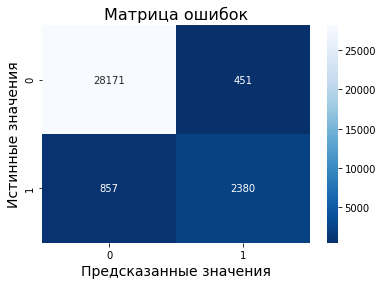

In [ ]:
# строим матрицу ошибок
cm = confusion_matrix(y_test, randomized_search_pac.best_estimator_.predict(tf_idf_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок', size=16)
plt.ylabel('Истинные значения', size=14)
plt.xlabel('Предсказанные значения', size=14)
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------

**Расшифровка графика:**

- Модель верно определила отсутствие нецензурной лексики в 28 171 случаях.
- Модель ошибочно распознала нецензурную лексику в 857 случае, хотя на самом деле ее не было.
- Модель правильно отметила наличие цензуры в 2380 случаях.
- Модель не увидела цензуру в 451 случаях, хотя она присутствовала.


--------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------

### Выводы блока (Обучение моделей):

- Были обучены три модели;
- Мы выбрали лучшую модель — PassiveAggressiveClassifier. Она соответствует требованию метрики f1, которая должна быть выше 0.75, и при этом работает шустрее среди остальных вариантов.

--------------------------------------------------------------------------------------------------------------------------------------

## Общий вывод

**Прогноз модели:**

Модель определила наличие нецензурной лексики в тексте. Точность ее работы оценивается метрикой F1 и состовляет 78% на тестовой выборке. Заказчик предоставил данные для обучения модели, но в них наблюдается дисбаланс классов. Проще говоря, представьте, что 90% текстов не содержат цензурной лексики, а оставшиеся 10% — с цензурой. Это плохо влияет на обучение модели и снижает ее точность. Для улучшения качества модели можно собрать больше данных с примерами нецензурной лексики, чтобы количество текстов с цензурой и без нее было примерно одинаковым — 50 на 50. Это повысит качество модели, и она сможет лучше улавливать взаимосвязи.

--------------------------------------------------------------------------------------------------------------------------------------

**Кратко о обучении моделей:**

В ходе работы, данные были подготовлены: удалены ненужные символы и лишние слова. Обучили три модели на данных и настроили параметр балансировки, чтобы уменьшить дисбаланс классов. Из трех вариантов была выбрана модель, которая показала наилучшие результаты по качеству и скорости.

--------------------------------------------------------------------------------------------------------------------------------------

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны